In [1]:
#import
import os
import sys
import numpy as np
import tensorflow as tf
import sklearn
import glob
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop

from sklearn.metrics import *
from sklearn.preprocessing import OneHotEncoder

from stego_classifier_extended import *
from stego_detector_extended import *
import random as rn

In [2]:
#Utils

def extract_1_lsb_features(dataset):
    lsb_training_set = dataset & 1
    lsb_training_set = lsb_training_set.reshape(dataset.shape[0], dataset.shape[1]*dataset.shape[2]*dataset.shape[3])
    return lsb_training_set

#convert to binary
def messageToBinary(message):
  if type(message) == str:
    return ''.join([ format(ord(i), "08b") for i in message ])
  elif type(message) == bytes or type(message) == np.ndarray:
    return [ format(i, "08b") for i in message ]
  elif type(message) == int or type(message) == np.uint8:
    return format(message, "08b")
  else:
    raise TypeError("Input type not supported")
  
#extract k lsb for each channel
def extract_k_lsb_features(data, k=4):
    count = 0
    lsb_training = []
    for img in data:
        count = count + 1
        if count % 50 == 0:
            print(count)
        binary_data = []
        for values in img:
            for pixel in values:
                r, g, b = messageToBinary(pixel)
                for i in range(1,k+1):
                    binary_data.append(int(r[-1-i+1]))  # extracting data from the least significant bit of red pixel
                    binary_data.append(int(g[-1-i+1]))  # extracting data from the least significant bit of green pixel
                    binary_data.append(int(b[-1-i+1]))  # extracting data from the least significant bit of blue pixel
                # split by 8-bits

        lsb_training.append(np.array(binary_data))
        

    return np.array(lsb_training)

# load images in the image_path
def load_images(image_path):
    images = []
    for f_name in sorted(glob.glob(image_path + '/*.png')):
        img = np.asarray(Image.open(f_name).convert('RGB'))
        images.append(img)
    return images

#convert an image into array
def convert_np_array(vector):
    result = []
    for v in vector:
        result.append(v)
    return np.array(result)

#laod data
def load_data(main_data_folder, usage_folder_name, legit_folder_name, stego_folder_names):
    
    data_path = os.path.join(main_data_folder, usage_folder_name)
    data_to_load = []
    num_stego_images_for_class = []
    data_to_load.append(convert_np_array(load_images(os.path.join(data_path,legit_folder_name))))
    for stego_folder_name in stego_folder_names:
        stego_images = convert_np_array(load_images(os.path.join(data_path,stego_folder_name)))
        num_stego_images_for_class.append(stego_images.shape[0])
        data_to_load.append(stego_images)

    num_legit_images = data_to_load[0].shape[0]
    print("#legit images", data_to_load[0].shape[0])
    print("#stego images", num_stego_images_for_class)

    data_to_load = np.concatenate(data_to_load)
    print("data shape: ", data_to_load.shape)

    print("done")
    
    return data_to_load, num_legit_images, np.array(num_stego_images_for_class)

#create target variable with labels
def create_target_labels(legits, stego_type_number):
    target = []
    i = 0
    target.append(np.zeros(legits, dtype=np.int8))
    for current_stego in stego_type_number:
        target.append(np.ones(current_stego, dtype=np.int8)+i)
        i=i+1
    return np.concatenate(target)

#create target variable
def create_target(legits, stegos):
    y_legit = np.zeros(legits, dtype=np.int8)
    y_stego = np.ones(stegos, dtype=np.int8)
    return np.concatenate([y_legit, y_stego])

def refresh_riproducibility(seed):
   
    #set seed 

    #Python SEED
    os.environ['PYTHONHASHSEED'] = '0'
    
    #numpy seed
    np.random.seed(seed)
    
    #tf seed
    tf.random.set_seed(seed)
    
    #rn seed
    rn.seed(seed)
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    
    #
    from tensorflow.compat.v1.keras import backend as K
    
    #sess
    sess = tf.compat.v1.get_default_session()
    K.set_session(sess)
    
    #tf seed
    tf.compat.v1.set_random_seed(seed)
    
    #os.environ['KERAS_BACKEND'] = "tensorflow"
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [3]:
#Parameters ---------------------------

#data_folder =  "/" # Debug data folder: "./data/debug"

data_folder = "./Dataset/dataset"
#data_folder = "./Dataset/subsample"
legit_folder = 'legit'
#stego_folders = ['LSB_stego_php','LSB_stego_url']
stego_folders = ['LSB_stego_url','LSB_stego_eth','LSB_stego_html','LSB_stego_js','LSB_stego_ps']
cwd = './'
model_space = 'output/models-separate_k1'
seed = 230782
k_lsb = 1 # we use only 2-bits
#------------------------------------

## Stego Malware Detection Task

In [4]:
#loading training set
training_set, num_training_legit, num_training_stego_for_class  = load_data(data_folder, "training", legit_folder, stego_folders)
num_training_stego = np.sum(num_training_stego_for_class)
num_targets = len(num_training_stego_for_class)+1
print("#training shape, neg, pos: ", training_set.shape, num_training_legit, num_training_stego)
print("#num classes: ", num_targets)

#legit images 4000
#stego images [2412, 2473, 2284, 2363, 2468]
data shape:  (16000, 512, 512, 3)
done
#training shape, neg, pos:  (16000, 512, 512, 3) 4000 12000
#num classes:  6


In [5]:
#lsb extraction
training_set = extract_1_lsb_features(training_set)






In [6]:
y_train = create_target(num_training_legit, num_training_stego)
print("training set ready")

training set ready


In [7]:
#loading validation set
validation, num_val_legit, num_val_stego_for_class  = load_data(data_folder, "validation", legit_folder, stego_folders)
num_val_stego = np.sum(num_val_stego_for_class)
print("#validation shape, neg, pos: ", validation.shape, num_val_legit, num_val_stego)

#lsb extraction
validation = extract_1_lsb_features(validation)
y_val = create_target(num_val_legit, num_val_stego)
print("validation set ready")


#legit images 2000
#stego images [1218, 1193, 1162, 1214, 1213]
data shape:  (8000, 512, 512, 3)
done
#validation shape, neg, pos:  (8000, 512, 512, 3) 2000 6000
validation set ready


In [8]:
#init classifier
#classifier = StegoClassifierExtended(training_set.shape[1], num_targets)
#detector = StegoDetectorExtended(training_set.shape[1])

#compile classifier
#classifier.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-3), metrics=['accuracy'])
#detector.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-3), metrics=['accuracy'])

#init callbacks
#model_path = os.path.join(cwd, model_space, 'best_model_stego_classification')
#print("best model path: ", model_path)
#check = ModelCheckpoint(model_path, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')


In [9]:
#model_path = os.path.join(cwd, model_space, 'best_model_stego_detection')
#print("best model path: ", model_path)
#check = ModelCheckpoint(model_path, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
#opt = ReduceLROnPlateau(monitor='val_loss', patience=3, min_lr=1e-9, factor=0.01, verbose=0)

In [10]:
import time

refresh_riproducibility(seed)

#init classifier
#classifier = StegoClassifierExtended(training_set.shape[1], num_targets)
detector = StegoDetectorExtended(training_set.shape[1])

#compile classifier
#classifier.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-3), metrics=['accuracy'])
detector.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-3), metrics=['accuracy'])

model_path = os.path.join(cwd, model_space, 'best_model_stego_detection')
print("best model path: ", model_path)
check = ModelCheckpoint(model_path, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
opt = ReduceLROnPlateau(monitor='val_loss', patience=3, min_lr=1e-9, factor=0.01, verbose=0)






start_time = int(round(time.time() * 1000))


#training model
history =   detector.fit(training_set, y_train, batch_size=256, epochs=20, 
                         validation_data=(validation, y_val), callbacks=[check, opt], verbose=1)

#history =   detector.fit(training_set, y_train, batch_size=256, epochs=20, 
#                         validation_data=(training_set, y_train), callbacks=[check, opt], verbose=1)

#training model
#history = classifier.fit(training_set, ohe_y_train, batch_size=256, epochs=20, 
#                         validation_data=(validation, ohe_y_val), callbacks=[check, opt], verbose=1)

end_time = int(round(time.time() * 1000))
total_time = end_time - start_time
#print(start_time)
#print(end_time)
print('Total Prediction Time:'+str(total_time))



best model path:  ./output/models-separate_k1/best_model_stego_detection


2022-06-10 11:57:03.829312: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-10 11:57:03.829343: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: b44220ace66e
2022-06-10 11:57:03.829351: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: b44220ace66e
2022-06-10 11:57:03.829448: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-06-10 11:57:03.829576: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-06-10 11:57:03.829586: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-06-10 11:57:03.829840: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instr

Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 0.5934 - accuracy: 0.6546

2022-06-10 12:03:01.377031: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6291456000 exceeds 10% of free system memory.
2022-06-10 12:03:02.378655: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6291456000 exceeds 10% of free system memory.


63/63 [==============================] - 374s 6s/step - loss: 0.5934 - accuracy: 0.6546 - val_loss: 0.4423 - val_accuracy: 0.7491 - lr: 0.0010
Epoch 2/20
63/63 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.7252

2022-06-10 12:09:08.622878: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6291456000 exceeds 10% of free system memory.


63/63 [==============================] - 358s 6s/step - loss: 0.4683 - accuracy: 0.7252 - val_loss: 0.5081 - val_accuracy: 0.7326 - lr: 0.0010
Epoch 3/20
63/63 [==============================] - 350s 6s/step - loss: 0.4293 - accuracy: 0.7462 - val_loss: 0.5291 - val_accuracy: 0.7220 - lr: 0.0010
Epoch 4/20
63/63 [==============================] - 364s 6s/step - loss: 0.3843 - accuracy: 0.7906 - val_loss: 0.3331 - val_accuracy: 0.8384 - lr: 0.0010
Epoch 5/20
63/63 [==============================] - 356s 6s/step - loss: 0.3202 - accuracy: 0.8391 - val_loss: 0.4085 - val_accuracy: 0.7916 - lr: 0.0010
Epoch 6/20
63/63 [==============================] - 358s 6s/step - loss: 0.2540 - accuracy: 0.8832 - val_loss: 0.1954 - val_accuracy: 0.9391 - lr: 0.0010
Epoch 7/20
63/63 [==============================] - 338s 5s/step - loss: 0.1959 - accuracy: 0.9193 - val_loss: 0.2533 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 8/20
63/63 [==============================] - 345s 5s/step - loss: 0.1515 - accur

Total Prediction Time:360956 \n
Total Prediction Time:445351 
--------------------------------
Total Prediction Time:383511
Total Prediction Time:483368

In [11]:
type(history.history)
his = history.history['loss']
df_his = pd.DataFrame(data=his, columns=["Loss"])
df_his['epoch'] = range(1, len(df_his) + 1)
print(df_his)

        Loss  epoch
0   0.593369      1
1   0.468309      2
2   0.429312      3
3   0.384317      4
4   0.320199      5
5   0.253961      6
6   0.195914      7
7   0.151467      8
8   0.129726      9
9   0.084342     10
10  0.056660     11
11  0.044403     12
12  0.035460     13
13  0.029731     14
14  0.028556     15
15  0.027773     16
16  0.027441     17
17  0.027997     18
18  0.027579     19
19  0.028830     20


In [12]:
#Save History
file_history = os.path.join(cwd, model_space, 'history')
print(file_history)
np.save(file_history,history.history)

# Load History
#history_read=np.load(file_history+'.npy', allow_pickle='TRUE').item()
#history_read

./output/models-separate_k1/history


/home/bmsa/env-max/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/bmsa/env-max/lib/python3.8/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


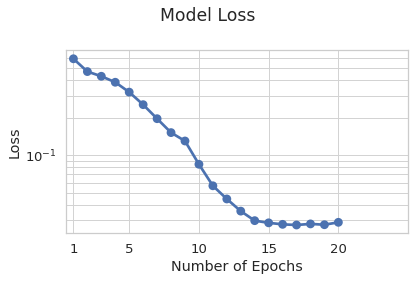

In [13]:
import seaborn as sns
#print history loss
sns.set()
sns.set(style='whitegrid', font_scale = 1.2)
#sns.set_style("darkgrid")
#sns.set_context("paper")

rc = {'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '.8',
      #'font.family':'Times New Roman',
      'font.height' : 16}
#plt.rcParams.update(rc)
#sns.set(font_scale = 1.1)

g = sns.factorplot(x ='epoch', y ='Loss', data = df_his,
               legend_out = False, size=4, aspect=1.5)
g.set(yscale='log')
#g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Model Loss')

g.axes[0,0].set_xlabel('Number of Epochs')
plt.xticks([0,4,9,14,19,24]) 
plt.grid(True, which="both",ls="-",c='#D3D3D3')
sns.despine(bottom = False, left = False, right=False, top=False)

new_labels = ['Stego Classifier']
plt.tight_layout() 

plt.savefig('output/training_loss.pdf')

/home/bmsa/env-max/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/bmsa/env-max/lib/python3.8/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


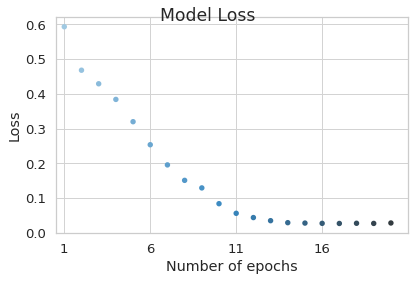

In [14]:
g = sns.factorplot(x='epoch', y="Loss", linestyles=["-", "--","-", "--"], markers=['.','x','v','+'], 
                   palette="Blues_d", legend_out = False, data=df_his, size=4, aspect=1.5)
type(g)

g.fig.suptitle('Model Loss')

g.axes[0,0].set_xlabel('Number of epochs')
plt.xticks([0, 5, 10, 15, 20]) 
plt.grid(True, which="both",ls="-",c='#D3D3D3') 
sns.despine(bottom = False, left = False, right=False, top=False)



new_labels = ['Stego Classifier']
#for t, l in zip(g._legend.texts, new_labels):
#    t.set_text(l)


In [15]:
g.fig.set_title("Plot", fontsize = 20)
g.set_xlabel("Number of epoch")
#g.set_ylabel("loss", fontsize = 20)
#g.set_title("Plot", fontsize = 20)

#g.fig.get_axes()[0].set_yscale('log')
plt.xticks([0, 5, 10, 15, 20]) 
plt.grid(True, which="both",ls="-",c='#D3D3D3') 
sns.despine(bottom = False, left = False, right=False, top=False)
g.set_xlabels("Number of epochs")

#g._legend.set_title("")
new_labels = ['Stego Classifier']
#for t, l in zip(g._legend.texts, new_labels):
#    t.set_text(l)

plt.tight_layout() 

plt.savefig('output/training_loss.pdf')

AttributeError: 'Figure' object has no attribute 'set_title'

In [ ]:
#reload best model
detector.load_weights(model_path)

In [16]:
#loading test set plain
test, num_test_legit, num_test_stego_for_class  = load_data(data_folder, "test_plain", legit_folder, stego_folders)
num_test_stego = np.sum(num_test_stego_for_class)
print("#test shape, neg, pos: ", test.shape, num_test_legit, num_test_stego)

#lsb extraction
test = extract_1_lsb_features(test)

#create target

y_test = create_target(num_test_legit, num_test_stego)
print("test set unseen ready")


#print("#num examples for class:")
#(unique, counts) = np.unique(y_test, return_counts=True)
#frequencies = np.asarray((unique, counts)).T
#print(frequencies)
#print("Apply OHE")
#ohe_y_test = ohe_processer.transform(np.reshape(y_test,(-1,1))).toarray()
#print("test set ready")

#legit images 2000
#stego images [1234, 1247, 1167, 1188, 1164]
data shape:  (8000, 512, 512, 3)
done
#test shape, neg, pos:  (8000, 512, 512, 3) 2000 6000
test set unseen ready


In [17]:
y_test

array([0, 0, 0, ..., 1, 1, 1], dtype=int8)

In [18]:
y_pred_score = detector.predict(test)

y_pred_label = np.around(y_pred_score, 0)

report_map = classification_report(y_test, y_pred_label, output_dict=True)

acc_score = accuracy_score(y_test, y_pred_label)

auc_score = roc_auc_score(y_test, y_pred_score)

pr1, rec1, thr1 = precision_recall_curve(y_test, y_pred_score)

auc_score_pr = auc(rec1, pr1)

result = str(acc_score)+";"+str(report_map['1']['precision']) + ";" + str(
        report_map['1']['recall']) + ";" + str(report_map['1']['f1-score']) + ";" + str(
        auc_score) + ";" + str(auc_score_pr)

print("acc;prec;rec;f1;auc;auc-pr")
print(result)

250/250 [==============================] - 42s 160ms/step
acc;prec;rec;f1;auc;auc-pr
0.99175;0.9994949494949495;0.9895;0.9944723618090452;0.9998479166666667;0.9999435265947455


In [19]:
#loading test set b64
test, num_test_legit, num_test_stego_for_class  = load_data(data_folder, "test_b64", legit_folder, stego_folders)

num_test_stego = np.sum(num_test_stego_for_class)
print("#test shape, neg, pos: ", test.shape, num_test_legit, num_test_stego)

#lsb extraction
test_b64 = extract_1_lsb_features(test)

#create target

y_test = create_target(num_test_legit, num_test_stego)
print("test set unseen ready")

#legit images 2000
#stego images [1234, 1247, 1167, 1188, 1164]
data shape:  (8000, 512, 512, 3)
done
#test shape, neg, pos:  (8000, 512, 512, 3) 2000 6000
test set unseen ready


In [20]:
y_pred_score = detector.predict(test_b64)

y_pred_label = np.around(y_pred_score, 0)

report_map = classification_report(y_test, y_pred_label, output_dict=True)

acc_score = accuracy_score(y_test, y_pred_label)

auc_score = roc_auc_score(y_test, y_pred_score)

pr1, rec1, thr1 = precision_recall_curve(y_test, y_pred_score)

auc_score_pr = auc(rec1, pr1)

result = str(acc_score)+";"+str(report_map['1']['precision']) + ";" + str(
        report_map['1']['recall']) + ";" + str(report_map['1']['f1-score']) + ";" + str(
        auc_score) + ";" + str(auc_score_pr)

print("acc;prec;rec;f1;auc;auc-pr")
print(result)

250/250 [==============================] - 55s 160ms/step
acc;prec;rec;f1;auc;auc-pr
0.9985;0.9994994994994995;0.9985;0.9989994997498749;0.9999379166666666;0.9999781130709715


In [21]:
#loading test set zip
test, num_test_legit, num_test_stego_for_class  = load_data(data_folder, "test_zip", legit_folder, stego_folders)

num_test_stego = np.sum(num_test_stego_for_class)
print("#test shape, neg, pos: ", test.shape, num_test_legit, num_test_stego)

#lsb extraction
test_zip = extract_1_lsb_features(test)

#create target

y_test = create_target(num_test_legit, num_test_stego)
print("test set unseen ready")

#legit images 2000
#stego images [1234, 1247, 1167, 1188, 1164]
data shape:  (8000, 512, 512, 3)
done
#test shape, neg, pos:  (8000, 512, 512, 3) 2000 6000
test set unseen ready


In [22]:
y_pred_score = detector.predict(test_zip)

y_pred_label = np.around(y_pred_score, 0)

report_map = classification_report(y_test, y_pred_label, output_dict=True)

acc_score = accuracy_score(y_test, y_pred_label)

auc_score = roc_auc_score(y_test, y_pred_score)

pr1, rec1, thr1 = precision_recall_curve(y_test, y_pred_score)

auc_score_pr = auc(rec1, pr1)

result = str(acc_score)+";"+str(report_map['1']['precision']) + ";" + str(
        report_map['1']['recall']) + ";" + str(report_map['1']['f1-score']) + ";" + str(
        auc_score) + ";" + str(auc_score_pr)

print("acc;prec;rec;f1;auc;auc-pr")
print(result)

250/250 [==============================] - 59s 162ms/step
acc;prec;rec;f1;auc;auc-pr
0.999625;0.9995002498750625;1.0;0.9997500624843789;0.9999985;0.9999994993320644
